In [1]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import tqdm
import scipy
from skimage.segmentation import find_boundaries, flood, expand_labels
import skimage.measure as measure
import skimage.morphology as morphology
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def get_intake_cat():

    '''
    Return the intake catalog for barra
    '''

    #See here: https://opus.nci.org.au/pages/viewpage.action?pageId=264241965
    data_catalog = intake.open_esm_datastore("/g/data/ob53/catalog/v2/esm/catalog.json")

    return data_catalog

def load_barra_static(domain_id,lon_slice,lat_slice):

    '''
    For a barra domain, load static variables
    domain_id: for barra, either AUS-04 or AUST-11
    lat_slice: a slice to restrict lat domain
    lon_slice: a slice to restrict lon domain
    '''

    data_catalog = get_intake_cat()
    orog = data_catalog.search(variable_id="orog",domain_id=domain_id).to_dask().sel(lon=lon_slice, lat=lat_slice)
    lsm = data_catalog.search(variable_id="sftlf",domain_id=domain_id).to_dask().sel(lon=lon_slice, lat=lat_slice)

    return orog.orog, (lsm.sftlf >= 0.5) * 1

def label_and_find_coast(lsm,erosion_footprint=morphology.disk(2),size_thresh=10):

    '''
    Given a binary land-sea mask Dataarray, label the array and find boundaries (coastline)
    using skimage

    Inputs:
    erosion_footprint: A disk used to smooth/erode the binary lsm, see:
    https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html#erosion
    size_thresh: A threshold on the number of pixels for a land mass to be considered as a coastline.
    note this is applied AFTER the erosion 

    Output:
    coastline_masks: A dictionary with keys as label numbers from 0 to N, and items as a coastline mask
    label_masks: A dictionary with keys as label numbers from 0 to N, and items as a label mask
    '''

    #Label the binary land sea mask, while applying an erosion method to remove
    #parts of the coast connected by skinny land bridges (the algorithm for ordering 
    #the coastline points has trouble with that)
    if erosion_footprint is not None:
        labelled_lsm = measure.label(morphology.binary_opening(lsm,footprint=erosion_footprint),connectivity=1)
    else:
        labelled_lsm = measure.label(lsm,connectivity=1)

    #Remove labelled land masses smaller than some size threshold
    unique_labels = np.unique(labelled_lsm)
    for l in unique_labels:
        if l>0:
            if (labelled_lsm==l).sum() <= size_thresh:
                labelled_lsm[labelled_lsm==l] = 0
    unique_labels = np.unique(labelled_lsm)                

    #Get boundaries (coastlines)
    coastline_masks = []
    label_masks = []
    for l in unique_labels:
        if l>0:
            coastline_masks.append(find_boundaries(labelled_lsm==l, connectivity=1, mode="inner"))
            label_masks.append(labelled_lsm==l)

    coastline_masks = dict(zip(np.arange(len(unique_labels)),coastline_masks))
    label_masks = dict(zip(np.arange(len(unique_labels)),label_masks))
    
    return coastline_masks, label_masks

In [2]:
lat_slice = slice(-45,-5)
lon_slice = slice(110,155)
orog, lsm = load_barra_static("AUS-11",lon_slice,lat_slice)
coastline_labels, label_masks = label_and_find_coast(lsm,erosion_footprint=None,size_thresh=10)

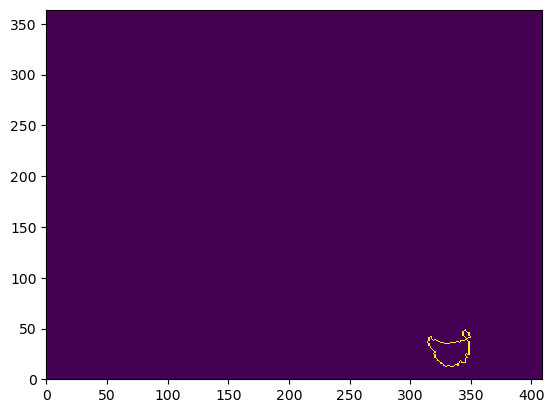

In [3]:
plt.pcolormesh(coastline_labels[0])

In [7]:
def get_coastline_angle_circle(coast_label, land_label, lsm):

    '''
    Ewan and Jarrah's method. Construct a "kernel" for each coastline point to all other points, then average. Done separately for each landmass

    Input
    label: a labelled coastline array
    lsm: xarray dataarray with a binary lsm, and lat lon info

    Output
    an array of coastline angles (0-360 degrees from N) for the labelled coastline array
    '''

    lon = lsm.lon.values
    lat = lsm.lat.values
    xx,yy = np.meshgrid(lon,lat)

    #Define coastline x,y indices from the coastline mask
    xl, yl = np.where(coast_label)

    angle_ls = []
    #Loop over coastline points
    for t in tqdm.tqdm(np.arange(len(xl))):
        angles = np.zeros(coast_label.shape).astype(complex) * np.nan
        #For each coastline point, calculate the vector between it and every other point, expressed as a complex number.
        #The array of complex numbers will be referred to as a kernel
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                angles[i,j] = (yy[i,j] - yy[xl[t],yl[t]])*1j + (xx[i,j] - xx[xl[t],yl[t]])                    

        #Keep track of the kernel for later averaging
        angle_ls.append(angles)
    
    #Stack the complex numbers over all coastline points
    stack = np.stack(angle_ls)
    
    #Create an inverse distance weighting function
    weights = (1/(np.abs(stack)))**4
    #weights = (1/np.exp(np.abs(stack)**5))

    #Take the weighted mean and convert complex numbers to an angle
    mean_angles = np.mean( (weights * stack) , axis=0)
    mean_angles = np.angle(mean_angles)

    #Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
    mean_angles = np.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))
    
    #Calculate the weighted circular variance
    total_weight = np.sum(weights, axis=0)
    normed_weight = weights/total_weight
    unit_stack = stack / np.abs(stack)
    variance = 1 - np.abs(np.sum(normed_weight*unit_stack, axis=0))

    return mean_angles, stack, variance
    
l = 0
mean_angles, stack, variance = get_coastline_angle_circle(coastline_labels[l], label_masks[l], lsm)

100%|██████████| 134/134 [00:51<00:00,  2.61it/s]
/jobfs/126055283.gadi-pbs/ipykernel_1256687/939209461.py:38: RuntimeWarning: divide by zero encountered in divide
  weights = (1/(np.abs(stack)))**4
/jobfs/126055283.gadi-pbs/ipykernel_1256687/939209461.py:42: RuntimeWarning: invalid value encountered in multiply
  mean_angles = np.mean( (weights * stack) , axis=0)
/jobfs/126055283.gadi-pbs/ipykernel_1256687/939209461.py:50: RuntimeWarning: invalid value encountered in divide
  normed_weight = weights/total_weight
/jobfs/126055283.gadi-pbs/ipykernel_1256687/939209461.py:51: RuntimeWarning: invalid value encountered in divide
  unit_stack = stack / np.abs(stack)


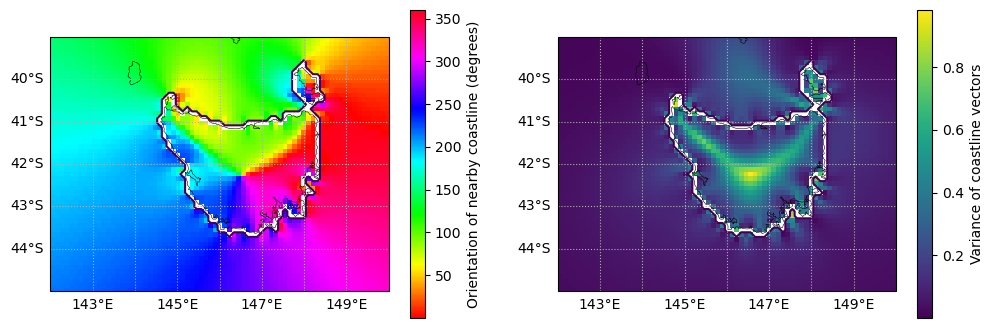

In [8]:
plt.figure(figsize=[12,4])
lon = lsm.lon
lat = lsm.lat
xx,yy = np.meshgrid(lon,lat)

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
c=ax.pcolormesh(xx,yy,np.rad2deg(mean_angles),cmap="hsv")
ax.contour(xx,yy,label_masks[l])
cb=plt.colorbar(c)
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
plt.ylim([-45,-39])
plt.xlim([142,150])
cb.set_label("Orientation of nearby coastline (degrees)")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=ax.pcolormesh(xx,yy,variance)
ax.contour(xx,yy,label_masks[l])
cb=plt.colorbar(c)
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
plt.ylim([-45,-39])
plt.xlim([142,150])
cb.set_label("Variance of coastline vectors")

In [9]:
# weights = (1/(np.abs(stack)))**3
# test = np.mean( (weights * stack) , axis=0)
# test2 = np.angle(test)

# plt.figure()
# lon = lsm.lon
# lat = lsm.lat
# xx,yy = np.meshgrid(lon,lat)
# ax=plt.axes(projection=ccrs.PlateCarree())
# total_weight = np.sum(weights, axis=0)
# normed_weight = weights/total_weight
# unit_stack = stack / np.abs(stack)
# variance = 1 - np.abs(np.sum(normed_weight*unit_stack, axis=0))
# c=ax.pcolormesh(xx,yy,variance)
# ax.contour(xx,yy,label_masks[0])
# plt.colorbar(c)
# ax.gridlines(draw_labels=["left","bottom"],ls=":")
# plt.ylim([-45,-39])
# plt.xlim([142,150])

# plt.figure()
# lon = lsm.lon
# lat = lsm.lat
# xx,yy = np.meshgrid(lon,lat)
# ax=plt.axes(projection=ccrs.PlateCarree())
# c=ax.pcolormesh(xx,yy,np.where(label_masks[0]==1,(test2+np.pi) % (2*np.pi),test2 % (2*np.pi)),cmap="hsv")
# ax.contour(xx,yy,label_masks[0])
# plt.colorbar(c)
# ax.gridlines(draw_labels=["left","bottom"],ls=":")
# plt.ylim([-45,-39])
# plt.xlim([142,150])